# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this homework we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset
    
data, attrs = fetch_lfw_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [3]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [4]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [5]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

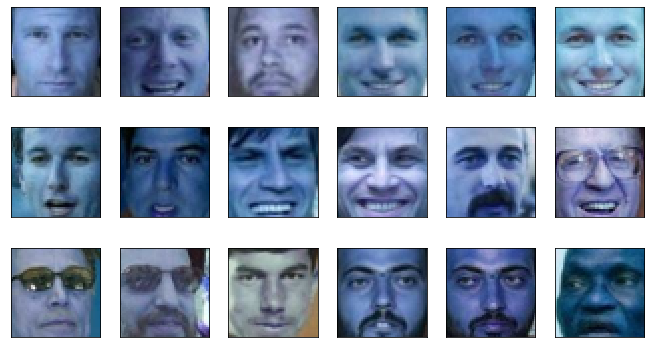

In [6]:
plot_gallery(X_train, image_h, image_w)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

<img src="Autoencoder_structure.png" alt="Autoencoder">

In [11]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers
from keras.models import Sequential
from keras import layers as L
from tensorflow.keras.models import Model

dimZ = 100 # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

# here I followed the idea Tensorflow Autoencoder tutorial with adaptation to your comments

initializer = tf.keras.initializers.GlorotNormal()

class Autoencoder(Model):
    def __init__(self, dimZ):
        super(Autoencoder, self).__init__()
        self.dimZ = dimZ   
        
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape=X_train.shape[1]),
                                        layers.Dense(2 * dimZ, activation='relu', kernel_initializer=initializer, bias_initializer='zeros'),
                                        layers.Dense(dimZ, activation='relu', kernel_initializer=initializer, bias_initializer='zeros'),])
        
        self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=dimZ),
                                        layers.Dense(2 * dimZ, activation='relu', kernel_initializer=initializer, bias_initializer='zeros'),
                                        layers.Dense(X_train.shape[1], activation='sigmoid', kernel_initializer=initializer, bias_initializer='zeros')])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(dimZ)

In [14]:
# Create MSE loss function
# Use Adam optimizer

from tensorflow.keras import losses
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [15]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
history = autoencoder.fit(X_train, X_train,
                epochs=10,
                shuffle=True,
                validation_data=(X_val, X_val))

Epoch 1/10
313/313 [==============================] - 2s 4ms/step - loss: 0.0079 - val_loss: 0.0057
Epoch 2/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 3/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 4/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 5/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 6/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 7/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 8/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 9/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 10/10
313/313 [==============================] - 1s 4ms/step - loss: 0.0050 - val_loss: 0.0054

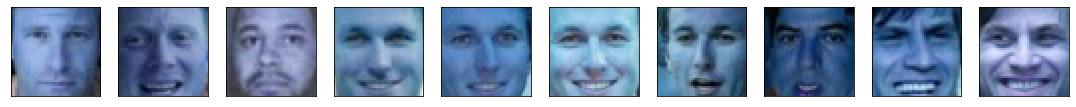

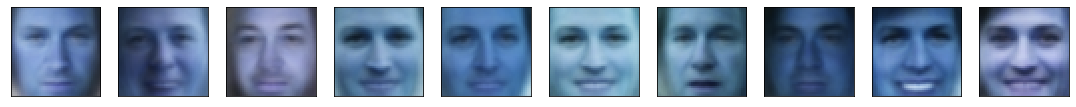

In [16]:
# Examine the reconstructions

def plot_gallery_2(images, h, w, n_row=1, n_col=10):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

# Examine the reconstructions
encoded_imgs = autoencoder.encoder(X_train).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plot_gallery_2(X_train[:18], image_h, image_w)

plot_gallery_2(decoded_imgs[:18], image_h, image_w)

Reconstruction is not bad, right?

#### yep, reconstructions are not very bad. 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

In [76]:
z = np.random.randn(25, dimZ)*0.5

print(z.shape)
# output = None # FIXME compute from decoder from z

# just simply giving this z to the autoencoder.decoder
output = autoencoder.decoder(z).numpy()

output

# plot_gallery(output, image_h, image_w, n_row=5, n_col=5)

(25, 100)


array([[0.18645811, 0.21584636, 0.23149528, ..., 0.28168398, 0.35536104,
        0.4330874 ],
       [0.24954136, 0.2991823 , 0.3420284 , ..., 0.30763918, 0.30211705,
        0.38172686],
       [0.19067703, 0.20684955, 0.19195962, ..., 0.24802464, 0.30536804,
        0.31705433],
       ...,
       [0.27401897, 0.31144476, 0.34480235, ..., 0.21599306, 0.22757062,
        0.244231  ],
       [0.3365434 , 0.33485648, 0.3323552 , ..., 0.31356508, 0.33434603,
        0.44985813],
       [0.39547464, 0.41891912, 0.42010534, ..., 0.3271439 , 0.34377885,
        0.36787027]], dtype=float32)

In [ ]:
# nice! this is very interesting! 

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

#### Depends on the encoder itself, huh? If we deal with an ideal encoder/decoder - than yep, but we understand, that this is possible only in theory

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [114]:
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 512

# define the network
# you can start from pytorch example https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST
import keras
from keras import backend as K 

K.clear_session()

initializer = tf.keras.initializers.GlorotNormal()

class VarAutoencoder(Model):
    def __init__(self, dimZ):
        super(VarAutoencoder, self).__init__()
        self.dimZ = dimZ   
        
        self.encoder = tf.keras.Sequential([ layers.InputLayer(input_shape=X_train.shape[1]),
                                        layers.Dense(4 * dimZ, activation='relu'),
                                        layers.Dense(2 * dimZ , activation='relu' )])
        
        self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=dimZ),
                                        layers.Dense(2 * dimZ, activation='relu'),
                                        layers.Dense(2 * X_train.shape[1] , activation='sigmoid')])
    
    def sample(self, random_var=None, testing=False):
        if random_var is None:
            random_var = tf.random.normal(shape(32, self.latent_dim))
        mean_gen, logvar_gen = self.decode(random_var)
        gaussian_rv = tf.random.normal(shape=mean_gen.shape)
        if testing:
            return mean_gen
        return mean_gen + gaussian_rv * tf.exp(logvar_gen * 0.5)
    
    def encode(self, x): # the same
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar): # the same
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    def decode(self, z): ####??? what???
        mean_gen, logvar_gen = tf.split(self.decoder(z), num_or_size_splits=2, axis = 1)
        return mean_gen, logvar_gen

  # def call(self, x):
  #   encoded = self.encoder(x)
  #   decoded = self.decoder(encoded)
  #   return decoded

varautoencoder = VarAutoencoder(dimZ)

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [115]:
def KL_divergence(mu, logvar):
    return -0.5 * tf.reduce_sum(1. + logvar - mu**2 - tf.exp(logvar))

def log_likelihood(x, mu, logvar):
    return  -0.5 * tf.reduce_sum((x-mu)**2/tf.exp(logvar) + 2 * tf.math.log(tf.sqrt(tf.exp(logvar))) + tf.math.log(2*np.pi))

def loss_vae(x, mu_gen, logvar_gen, mu_z, logvar_z):
    return - KL_divergence(mu_z, logvar_z) + log_likelihood(x, mu_gen, logvar_gen)

# def KL_divergence(mu, logsigma):
#     return 0

# def log_likelihood(x, mu, logsigma):
#     return 0

# def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
#     return 0

And train the model:

In [116]:
# train your autoencoder
# visualize progress in reconstruction and loss decay

optimizer = keras.optimizers.Adam(learning_rate=0.5)

def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        mean, logvar = model.encode(x)
        # print(KL_divergence(mean, logvar))

        z = model.reparameterize(mean, logvar)
        mean_gen, logvar_gen = model.decode(z)
        decoded_x = model.sample(z)
        # print(log_likelihood(decoded_x, mean_gen, logvar_gen))

        loss = loss_vae(decoded_x, mean_gen, logvar_gen, mean, logvar)
        # print(loss)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

for i in range(1000000000):
  if i %10000000==0:
    print(i)
    vvv = train_step(varautoencoder, X_train, optimizer)
    print(vvv)

0
tf.Tensor(-101979780.0, shape=(), dtype=float32)
10000000
tf.Tensor(-inf, shape=(), dtype=float32)
20000000
tf.Tensor(-110035130.0, shape=(), dtype=float32)
30000000
tf.Tensor(-111346910.0, shape=(), dtype=float32)
40000000
tf.Tensor(-113363820.0, shape=(), dtype=float32)
50000000
tf.Tensor(-114785400.0, shape=(), dtype=float32)
60000000
tf.Tensor(-115766120.0, shape=(), dtype=float32)
70000000
tf.Tensor(-116467096.0, shape=(), dtype=float32)
80000000
tf.Tensor(-116970540.0, shape=(), dtype=float32)
90000000
tf.Tensor(-117384776.0, shape=(), dtype=float32)
100000000
tf.Tensor(-117744840.0, shape=(), dtype=float32)
110000000
tf.Tensor(-118112520.0, shape=(), dtype=float32)
120000000
tf.Tensor(-118526630.0, shape=(), dtype=float32)
130000000
tf.Tensor(-119058640.0, shape=(), dtype=float32)
140000000
tf.Tensor(-119780080.0, shape=(), dtype=float32)
150000000
tf.Tensor(-120828620.0, shape=(), dtype=float32)
160000000
tf.Tensor(-122396810.0, shape=(), dtype=float32)
170000000
tf.Tensor(-1

KeyboardInterrupt: ignored

In [117]:
train_step(varautoencoder, X_train, optimizer)

<tf.Tensor: shape=(), dtype=float32, numpy=-1.1873513e+16>

In [120]:
# test your autoencoder with validation data
mean, logvar = varautoencoder.encode(X_train)
z = varautoencoder.reparameterize(mean, logvar)
mean_gen, logvar_gen = varautoencoder.decode(z)
decoded_x = varautoencoder.sample(z)

# decoded_x = (decoded_x - np.min(decoded_x, axis = 0)) / (np.max(decoded_x, axis = 0) - np.min(decoded_x, axis = 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

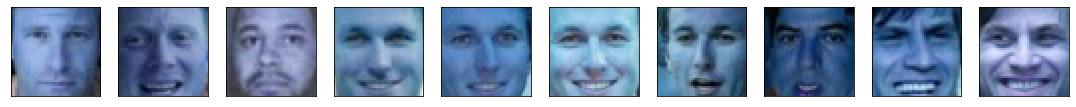

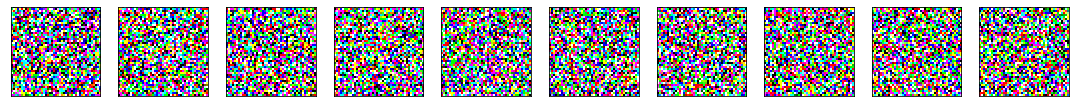

In [121]:
def plot_gallery_3(images, h, w, n_row=1, n_col=10):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(tf.reshape(images[i], (h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

plot_gallery_3(X_train[:18], image_h, image_w)
plot_gallery_3(decoded_x[:18], image_h, image_w)

And finally sample from VAE.

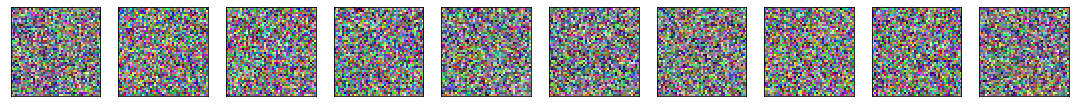

In [112]:
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

z = np.random.randn(25, dimZ)*0.5
mean_gen, logvar_gen = varautoencoder.decode(z)
decoded_x = varautoencoder.sample(z).numpy()
decoded_x = (decoded_x - np.min(decoded_x, axis = 0)) / (np.max(decoded_x, axis = 0) - np.min(decoded_x, axis = 0))


plot_gallery_3(decoded_x, image_h, image_w, n_row=1, n_col=10)

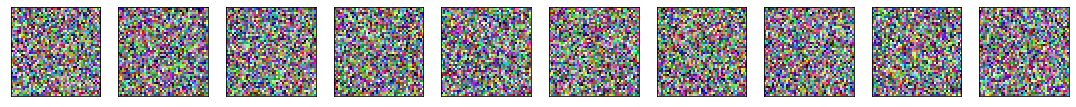

In [113]:
x = np.random.randn(10, X_train.shape[1])*0.5

mean, logvar = varautoencoder.encode(x)
z = varautoencoder.reparameterize(mean, logvar)
mean_gen, logvar_gen = varautoencoder.decode(z)
decoded_x = varautoencoder.sample(z)
decoded_x = (decoded_x - np.min(decoded_x, axis = 0)) / (np.max(decoded_x, axis = 0) - np.min(decoded_x, axis = 0))

plot_gallery_3(decoded_x, image_h, image_w, n_row=1, n_col=10)

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column, but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">